In [54]:
import numpy as np
from scipy.stats import norm, binom, poisson, rankdata, chi2, kstwobign, logistic, cauchy, rankdata
from scipy import stats
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as py
import pandas as pd

In [151]:
NUM_EXPERIMENTS = 10000
SAMPLE_SIZE = 50

In [122]:
def t_statistic(m, n, phi, X, Y):
    N = m + n
    ranked = np.array(pd.DataFrame(np.hstack([X,Y])).rank()).flatten()
    ranked_X = ranked[:m]
    ranked_Y = ranked[m:]
    sum_1 = sum(phi((ranked_X - 0.5) / N))
    sum_2 = sum(phi((ranked_Y - 0.5) / N))
    return np.sqrt(m*n/N) * (1/m * sum_1 - 1/n * sum_2)

def phi_1(x):
    return np.sqrt(3)*(2*x - 1)

def phi_2(x):
    return np.sqrt(48) * (0.25 - abs(x - 0.5))

In [123]:
def get_T_statistic(f):
    def statistic(ns, ms):
        n, m = len(ns), len(ms)
        N = n + m
        zs = np.concatenate((ms, ns))
        arg_order = rankdata(zs)
        return (np.sqrt((n*m)/N) * ((1/m) * np.sum(f((arg_order[:m] - 0.5)/N)) - (1/n) * np.sum(f((arg_order[m:] - 0.5)/N))))**2
    return statistic

def KS(ns, ms):
    m, n = len(ms), len(ns)
    return np.sqrt(m*n/(m+n)) * stats.kstest(rvs=ns, cdf=ms).statistic

In [124]:
# statistics_p = {'KS': KS, 'W': lambda ns, ms: t_statistic(len(ms), len(ns), phi_1, ns, ms)**2,
#               'AB': lambda ns, ms: t_statistic(len(ms), len(ns), phi_2, ns, ms)**2}
# statistics_p['L'] = lambda ns, ms: statistics_p['AB'](ns, ms) + statistics_p['W'](ns, ms)

In [125]:
statistics = {'KS': KS, 'W': get_T_statistic(lambda u: np.sqrt(3)*(2*u-1)),
              'AB': get_T_statistic(lambda u: np.sqrt(48)*(0.25-np.abs(u-0.5)))}
statistics['L'] = lambda ns, ms: statistics['AB'](ns, ms) + statistics['W'](ns, ms)

In [126]:
ms = norm.rvs(loc=0, scale=1, size=SAMPLE_SIZE)
ns = norm.rvs(loc=0, scale=1, size=SAMPLE_SIZE)

print(statistics_p['W'](ns, ms))
print(statistics['W'](ns,ms))

1.2607500000000003
1.2607500000000003


### EX.1

In [127]:
# Asymptotic valus
print(chi2.ppf(0.95, 1))
print(chi2.ppf(0.95, 2))
print(kstwobign.ppf(0.95))

3.841458820694124
5.991464547107979
1.3580986393225505


In [128]:
results = np.zeros((4,NUM_EXPERIMENTS))

In [129]:
for i in tqdm(range(NUM_EXPERIMENTS)):
    ms = norm.rvs(loc=0, scale=1, size=SAMPLE_SIZE)
    ns = norm.rvs(loc=0, scale=1, size=SAMPLE_SIZE)
    for j, statistic in enumerate(statistics.values()):
        results[j][i] = statistic(ns, ms)

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1829.20it/s]


In [130]:
np.set_printoptions(precision=2)
quantiles = np.quantile(results, 0.95, axis=1)
print(quantiles)

[1.26 3.89 4.11 6.11]


In [131]:
critical_values = [(kstwobign.ppf(0.95), 'KS'), (chi2.ppf(0.95, 1), 'W'), (chi2.ppf(0.95, 1), 'AB'), (chi2.ppf(0.95, 2), 'L')]

In [152]:
def estimate_power(t_stats, critical_value):
    return np.sum(t_stats > critical_value) / len(t_stats)

def create_plot(powers, xs, title):
    for j, (cv, name) in enumerate(critical_values):
        plt.plot(xs, powers[:,j], label = name)
        print(powers[:, j], '  ', name)
    plt.title(title)
    plt.legend()

In [153]:
def run_experiment(params, dist, title, xs):
    results = np.zeros((len(params), NUM_EXPERIMENTS, 4))
    for i, (mu_1, mu_2, sigma_1, sigma_2) in enumerate(params):
        for j in tqdm(range(NUM_EXPERIMENTS)):
            if dist == 'uniform':
                ns = np.random.rand(SAMPLE_SIZE)
                ms = np.random.rand(SAMPLE_SIZE)
            else:
                ms = dist.rvs(loc=mu_1, scale=sigma_1, size=SAMPLE_SIZE)
                ns = dist.rvs(loc=mu_2, scale=sigma_2, size=SAMPLE_SIZE)
            for k, statistic in enumerate(statistics.values()):
                results[i][j][k] = statistic(ns, ms)
    
    powers = np.zeros((len(params), 4))
    for i in range(len(params)):
        for j, (cv, name) in enumerate(critical_values):
            powers[i][j] = estimate_power(results[i,:,j], cv)
    
    
    if xs is not None:
        create_plot(powers, xs, title)
    else:
        print('Statistics quantiles:', np.quantile(results, 0.95, axis=1))
        

### EX. 2

#### a)

In [134]:
params_a = [(0, mu, 1, 1) for mu in np.linspace(0.2, 1.4, 7)]
params_a

[(0, 0.2, 1, 1),
 (0, 0.4, 1, 1),
 (0, 0.6, 1, 1),
 (0, 0.8, 1, 1),
 (0, 1.0, 1, 1),
 (0, 1.2, 1, 1),
 (0, 1.4, 1, 1)]

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1894.83it/s]


[0.06 0.15 0.31 0.51 0.71 0.86 0.95]    KS
[0.1  0.24 0.45 0.68 0.86 0.95 0.99]    W
[0.06 0.04 0.04 0.03 0.02 0.01 0.01]    AB
[0.08 0.17 0.34 0.56 0.77 0.9  0.97]    L


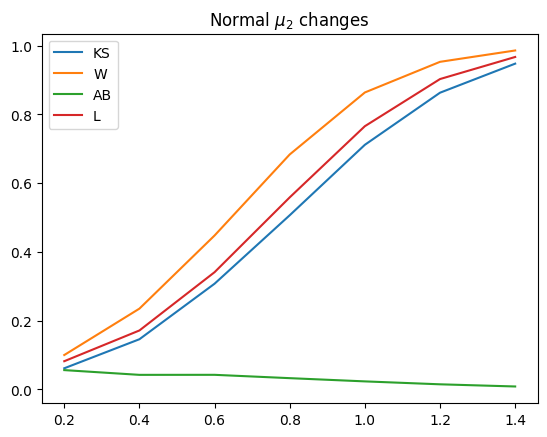

In [135]:
run_experiment(params_a, norm, 'Normal $\mu_2$ changes', np.linspace(0.2, 1.4, 7))

#### b)

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1871.22it/s]


[0.05 0.07 0.13 0.21 0.3  0.43 0.56]    KS
[0.08 0.11 0.19 0.3  0.43 0.56 0.7 ]    W
[0.06 0.05 0.05 0.05 0.04 0.04 0.04]    AB
[0.07 0.09 0.14 0.22 0.33 0.45 0.58]    L


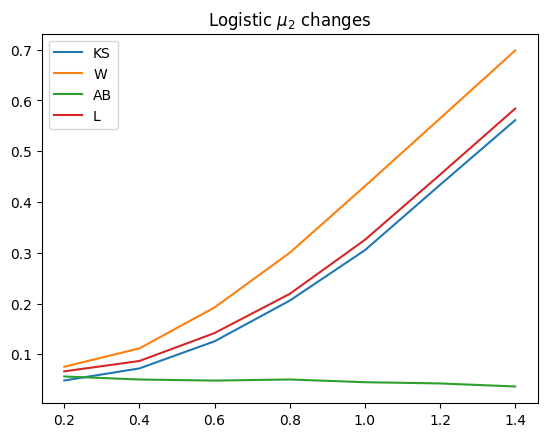

In [136]:
run_experiment(params_a, logistic, 'Logistic $\mu_2$ changes', np.linspace(0.2, 1.4, 7))

#### c)

In [137]:
params_c = [(0, mu, 1, 1) for mu in np.linspace(0.0, 3.0, 7)]
params_c

[(0, 0.0, 1, 1),
 (0, 0.5, 1, 1),
 (0, 1.0, 1, 1),
 (0, 1.5, 1, 1),
 (0, 2.0, 1, 1),
 (0, 2.5, 1, 1),
 (0, 3.0, 1, 1)]

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1649.21it/s]


[0.03 0.12 0.38 0.68 0.87 0.95 0.99]    KS
[0.05 0.14 0.37 0.63 0.8  0.91 0.95]    W
[0.05 0.06 0.07 0.09 0.11 0.11 0.11]    AB
[0.05 0.12 0.3  0.55 0.75 0.87 0.93]    L


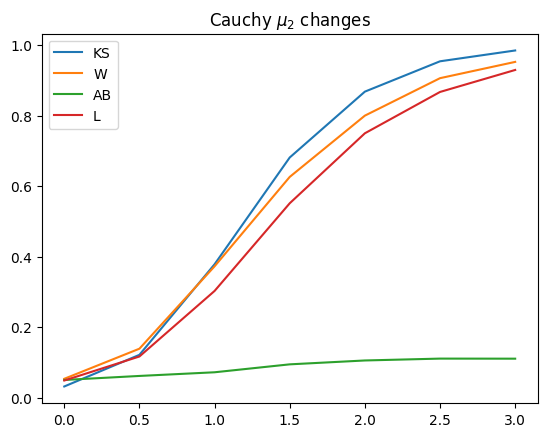

In [138]:
run_experiment(params_c, cauchy, 'Cauchy $\mu_2$ changes', np.linspace(0.0, 3.0, 7))

### EX. 3

#### a)

In [154]:
params_a = [(0, 0, 1, sigma) for sigma in np.linspace(1.0, 4.0, 7)]
params_a

[(0, 0, 1, 1.0),
 (0, 0, 1, 1.5),
 (0, 0, 1, 2.0),
 (0, 0, 1, 2.5),
 (0, 0, 1, 3.0),
 (0, 0, 1, 3.5),
 (0, 0, 1, 4.0)]

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1718.65it/s]


[0.04 0.12 0.38 0.69 0.88 0.96 0.99]    KS
[0.05 0.05 0.06 0.07 0.07 0.08 0.08]    W
[0.05 0.58 0.95 1.   1.   1.   1.  ]    AB
[0.05 0.48 0.91 0.99 1.   1.   1.  ]    L


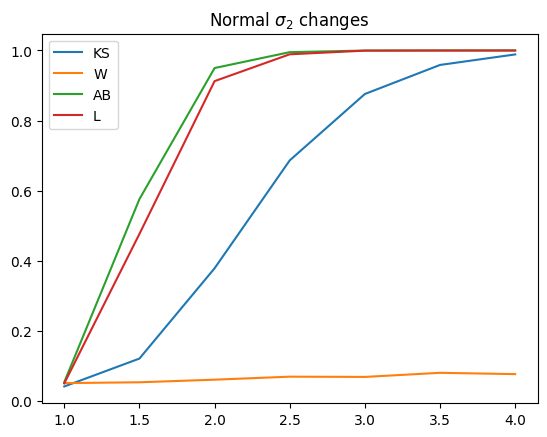

In [155]:
run_experiment(params_a, norm, 'Normal $\sigma_2$ changes', np.linspace(1.0, 4.0, 7))

#### b)

In [156]:
params_a = [(0, 0, 1, sigma) for sigma in np.linspace(1.0, 4.0, 7)]
params_a

[(0, 0, 1, 1.0),
 (0, 0, 1, 1.5),
 (0, 0, 1, 2.0),
 (0, 0, 1, 2.5),
 (0, 0, 1, 3.0),
 (0, 0, 1, 3.5),
 (0, 0, 1, 4.0)]

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1591.58it/s]


[0.04 0.12 0.34 0.61 0.81 0.92 0.98]    KS
[0.05 0.05 0.06 0.07 0.07 0.07 0.07]    W
[0.05 0.52 0.92 0.99 1.   1.   1.  ]    AB
[0.05 0.42 0.88 0.98 1.   1.   1.  ]    L


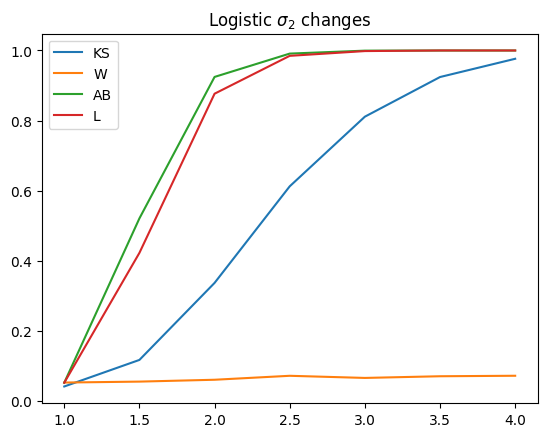

In [157]:
run_experiment(params_a, logistic, 'Logistic $\sigma_2$ changes', np.linspace(1.0, 4.0, 7))

#### c)

In [158]:
params_c = [(0, 0, 1, sigma) for sigma in np.linspace(1.0, 7.0, 7)]
params_c

[(0, 0, 1, 1.0),
 (0, 0, 1, 2.0),
 (0, 0, 1, 3.0),
 (0, 0, 1, 4.0),
 (0, 0, 1, 5.0),
 (0, 0, 1, 6.0),
 (0, 0, 1, 7.0)]

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1737.17it/s]


[0.04 0.18 0.45 0.7  0.85 0.92 0.96]    KS
[0.05 0.05 0.06 0.07 0.07 0.07 0.08]    W
[0.05 0.64 0.95 1.   1.   1.   1.  ]    AB
[0.05 0.54 0.92 0.99 1.   1.   1.  ]    L


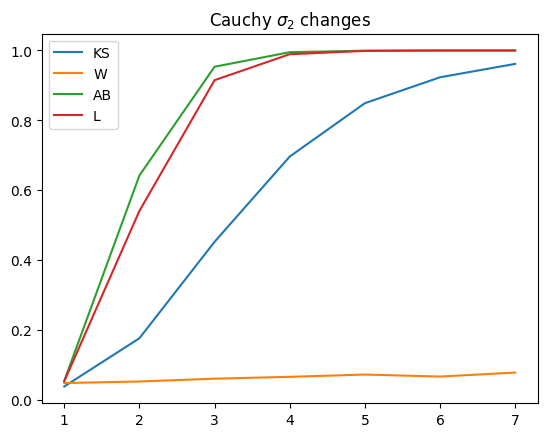

In [159]:
run_experiment(params_c, cauchy, 'Cauchy $\sigma_2$ changes', np.linspace(1.0, 7.0, 7))

### Ex. 4

#### a)

In [160]:
params_a = [(0, mu, 1, sig) for (sig,mu) in zip(np.linspace(1.0, 4.0, 7), np.linspace(0.2, 1.4, 7))]
params_a
changable = list(str(sm) for sm in zip(np.linspace(1.0, 4.0, 7), np.linspace(0.2, 1.4, 7)))

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1834.50it/s]


[0.12 0.39 0.75 0.92 0.98 0.99 1.  ]    KS
[0.17 0.34 0.45 0.53 0.57 0.61 0.62]    W
[0.05 0.55 0.94 0.99 1.   1.   1.  ]    AB
[0.13 0.65 0.97 1.   1.   1.   1.  ]    L


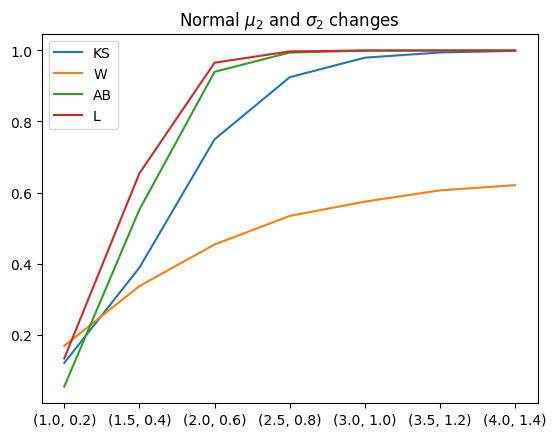

In [161]:
run_experiment(params_a, norm, 'Normal $\mu_2$ and $\sigma_2$ changes', changable)

#### b)

In [162]:
params_a = [(0, mu, 1, sig) for (sig,mu) in zip(np.linspace(1.0, 4.0, 7), np.linspace(0.2, 1.4, 7))]
params_a

[(0, 0.2, 1, 1.0),
 (0, 0.4, 1, 1.5),
 (0, 0.6, 1, 2.0),
 (0, 0.8, 1, 2.5),
 (0, 1.0, 1, 3.0),
 (0, 1.2, 1, 3.5),
 (0, 1.4, 1, 4.0)]

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1723.87it/s]


[0.07 0.22 0.51 0.75 0.91 0.96 0.99]    KS
[0.09 0.15 0.21 0.25 0.29 0.31 0.32]    W
[0.05 0.52 0.92 0.99 1.   1.   1.  ]    AB
[0.07 0.5  0.91 0.99 1.   1.   1.  ]    L


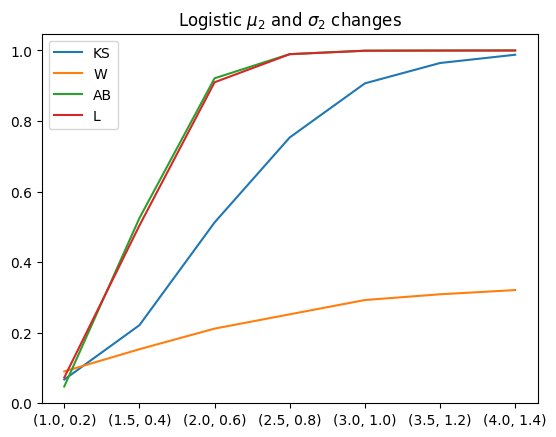

In [163]:
run_experiment(params_a, logistic, 'Logistic $\mu_2$ and $\sigma_2$ changes', changable)

#### c)

In [164]:
params_c = [(0, mu, 1, sig) for (sig,mu) in zip(np.linspace(1.0, 7.0, 7), np.linspace(0.0, 3.0, 7))]
changable = list(str(sm) for sm in zip(np.linspace(1.0, 7.0, 7), np.linspace(0.0, 3.0, 7)))
params_c

[(0, 0.0, 1, 1.0),
 (0, 0.5, 1, 2.0),
 (0, 1.0, 1, 3.0),
 (0, 1.5, 1, 4.0),
 (0, 2.0, 1, 5.0),
 (0, 2.5, 1, 6.0),
 (0, 3.0, 1, 7.0)]

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1563.59it/s]


[0.04 0.32 0.7  0.89 0.96 0.99 0.99]    KS
[0.05 0.16 0.28 0.38 0.44 0.48 0.52]    W
[0.05 0.63 0.94 0.99 1.   1.   1.  ]    AB
[0.05 0.61 0.94 0.99 1.   1.   1.  ]    L


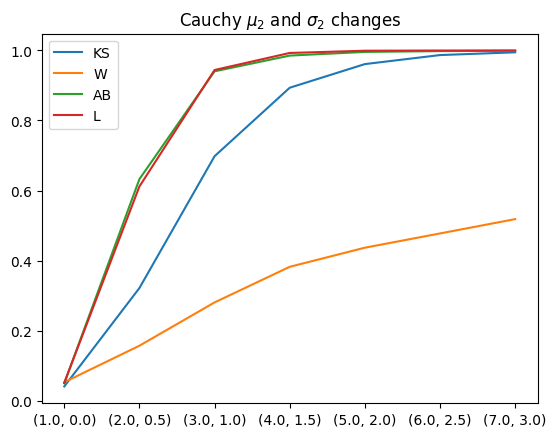

In [165]:
run_experiment(params_c, cauchy, 'Cauchy $\mu_2$ and $\sigma_2$ changes', changable)

### Ex. 5

In [166]:
SAMPLE_SIZE = 50

In [ ]:
run_experiment([(1,1,1,1)], 'uniform', '', None)

### Ex. 6